In [1]:
import torch
import argparse
import csv   
import datetime

import math
import torch.nn as nn 
from torch.nn.functional import leaky_relu, softmax
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from collections import Counter

from GANutils import *
from utils import *
from validationUtils import *
from plotUtils import *
from TUutils import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import clear_output

#### Visualise the MADGAN Training

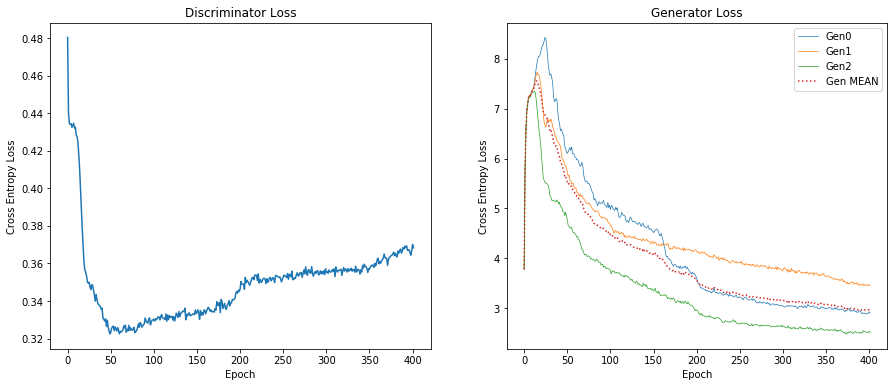

In [27]:
# Creates four polar axes, and accesses them through the returned array
df = pd.read_csv('Logs/madgan-2019-12-29_182519.csv', header=None) # LATEST MADGAN model

fig, axes = plt.subplots(1, 2, figsize=(15,6))

axes[0].plot(df[1]/2)
axes[0].set_title('Discriminator Loss')
axes[0].set_ylabel('Cross Entropy Loss')
axes[0].set_xlabel('Epoch')


axes[1].plot(df[3], linewidth=0.7)
axes[1].plot(df[4], linewidth=0.7)
axes[1].plot(df[5], linewidth=0.7)
axes[1].plot(df[2], linestyle = ':')
axes[1].legend(['Gen0', 'Gen1', 'Gen2', 'Gen MEAN'])
axes[1].set_title('Generator Loss')
axes[1].set_ylabel('Cross Entropy Loss')
axes[1].set_xlabel('Epoch')

'''
axes[1, 1].plot(df[3] - df[4])
axes[1, 1].set_title('Margin')
axes[1, 1].set_ylabel('Score')
axes[1, 1].set_xlabel('Epoch')
'''

plt.show()
fig.savefig('Figs/madgan_train.png')

#### Import Real Data, Functions and Classes

In [12]:
data = pd.read_pickle('Data/TU_onehot')
data = back_from_dummies(data)
data = data.drop(['HomeAdrMunCode'], axis=1)
data_oh = encode_onehot(data)

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:3606: FutureWarning: SparseDataFrame is deprecated and will be removed in a future version.
Use a regular DataFrame whose columns are SparseArrays instead.

See http://pandas.pydata.org/pandas-docs/stable/user_guide/sparse.html#migrating for more.

  result = self._constructor(new_data).__finalize__(self)


In [13]:
#device = torch.device('cpu')
def gen_noise(size:int, batch_size:int):
    '''
    Generates a 1-d vector of gaussian sampled random values
    '''
    n = Variable(torch.randn([batch_size,size]), requires_grad=False)
    return n
def sample_gumbel(shape, eps=1e-20):
    unif = torch.rand(*shape).to(device)
    g = -torch.log(-torch.log(unif + eps))
    return g.to(device)

def sample_gumbel_softmax(logits, temperature):
    """
        Input:
        logits: Tensor of log probs, shape = BS x k
        temperature = scalar
        
        Output: Tensor of values sampled from Gumbel softmax.
                These will tend towards a one-hot representation in the limit of temp -> 0
                shape = BS x k
    """
    g = sample_gumbel(logits.shape)
    h = (g + logits).to(device)/temperature.to(device)
    h_max = h.max(dim=-1, keepdim=True)[0]
    h = h - h_max
    cache = torch.exp(h).to(device)
    y = cache / cache.sum(dim=-1, keepdim=True)
    return y

INPUT_SIZE = 100
cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if cuda else "cpu")
device = torch.device('cpu')

In [15]:
class Generator (nn.Module):
    def __init__(self, 
                 input_size: int, 
                 hidden_size: int, 
                 temperature: float,
                 cat: Counter):
        super(Generator, self).__init__()
        self.cat = cat
        self.cat_n = list(cat.values())
        self.output_size = sum(self.cat.values())
        self.temperature = torch.Tensor([temperature]).to(device)
        self.l1 = nn.Sequential( 
            nn.Linear(input_size, hidden_size),
            nn.LeakyReLU(negative_slope=0.2),
            nn.BatchNorm1d(hidden_size, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.Dropout(0.3)
        )
        self.l2 = nn.Sequential( 
            nn.Linear(hidden_size, hidden_size * 2),
            nn.LeakyReLU(negative_slope = 0.2),
            nn.BatchNorm1d(hidden_size * 2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.Dropout(0.3)
        )
        self.l3 = nn.Sequential( 
            nn.Linear(hidden_size * 2, hidden_size * 3),
            nn.LeakyReLU(negative_slope = 0.2),
            nn.BatchNorm1d(hidden_size * 3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.Dropout(0.3)
        )
        self.l4 = nn.Sequential( 
            nn.Linear(hidden_size * 3, hidden_size * 2),
            nn.LeakyReLU(negative_slope = 0.2),
            nn.BatchNorm1d(hidden_size * 2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.Dropout(0.3)
        )
        self.out = nn.Sequential( 
            nn.Linear(hidden_size * 2, self.output_size))
        
    def forward(self,x):
        x=self.l1(x)
        x=self.l2(x)
        x=self.l3(x)
        x=self.l4(x)
        x=self.out(x)
        ### Softmax per class
        x = (x.split(self.cat_n, dim=1))
        out = torch.cat([sample_gumbel_softmax(v, temperature = self.temperature) for v in x], dim=1)
        return out

NUM_GEN = 3
G=[]
for i in range(NUM_GEN):
    G.append(torch.load('Logs/madgan-2019-12-29_182519G' + str(i)).to(device))

In [16]:
z = gen_noise(INPUT_SIZE, 30000).to(device)

In [25]:
fake_oh = pd.DataFrame( columns=data_oh.columns)
for i in range(NUM_GEN):
    output = G[i].forward(z)
    output = output.cpu().detach().numpy()
    output = output.astype(int)
    fake_oh = fake_oh.append(pd.DataFrame(output, columns=data_oh.columns))
#fake_oh.head()

In [26]:
fake_oh = fake_oh.astype(int)
fake = back_from_dummies(fake_oh)
#fake.head()

In [20]:
data = data.astype('category')
fake = fake.astype('category')

#### Partial Distributions

MAE:5.4716342012318805e-05, MSE:2.3468715127194274e-06, RMSE:0.0015319502318024, SRSME:0.16339525797493698
corr = 0.815402
MAE = 0.000692
RMSE = 0.005450
SRMSE = 4.899134
r2 = 0.477969


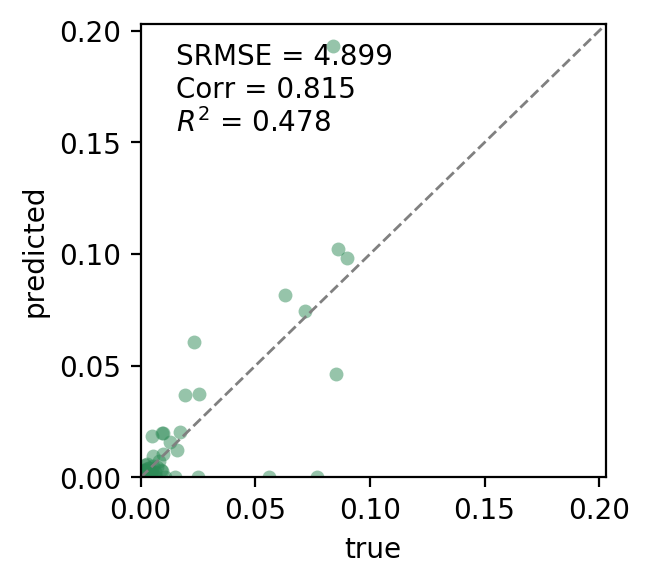

count_real  count_sampled  \
RespPrimOcc ResphasDrivlic RespAgeCorrect                                  
107         -18            (0.00198, 0.00702]    0.089822       0.098200   
                           (0.00702, 0.00904]    0.025600       0.037178   
            1              (0.00198, 0.00702]    0.000078       0.000933   
                           (0.00702, 0.00904]    0.000006       0.000511   
            2              (0.00702, 0.00904]    0.000484       0.000489   
...                                                   ...            ...   
158         1              (0.00702, 0.00904]    0.000000       0.000011   
                           (0.0202, 0.0228]      0.000000       0.000011   
172         1              (0.00904, 0.0124]     0.000000       0.000011   
168         1              (0.0202, 0.0228]      0.000000       0.000011   
269         -18            (0.00702, 0.00904]    0.000000       0.000011   

                                                   diff  
RespPrimOcc ResphasDrivlic RespAgeCorrect                
107         -18            (0.00198, 0.00702] -0.008378  
                           (0.00702, 0.00904] -0.011578  
            1              (0.00198, 0.00702] -0.000856  
                           (0.00702, 0.00904] -0.000505  
            2              (0.00702, 0.00904] -0.000005  
...                                                 ...  
158         1              (0.00702, 0.00904] -0.000011  
                           (0.0202, 0.0228]   -0.000011  
172         1              (0.00904, 0.0124]  -0.000011  
168         1              (0.0202, 0.0228]   -0.000011  
269         -18            (0.00702, 0.00904] -0.000011  

[899 rows x 3 columns]

In [21]:
### This combination amounts to 1k different combinations
evaluate(data, fake,  ['RespPrimOcc', 'ResphasDrivlic', 'RespAgeCorrect'], data.columns, data, data)


MAE:1.150105321436284e-06, MSE:3.544087612052198e-09, RMSE:5.953224010611559e-05, SRSME:0.047516126502309984
corr = 0.857668
MAE = 0.000107
RMSE = 0.000574
SRMSE = 3.931798
r2 = 0.630248


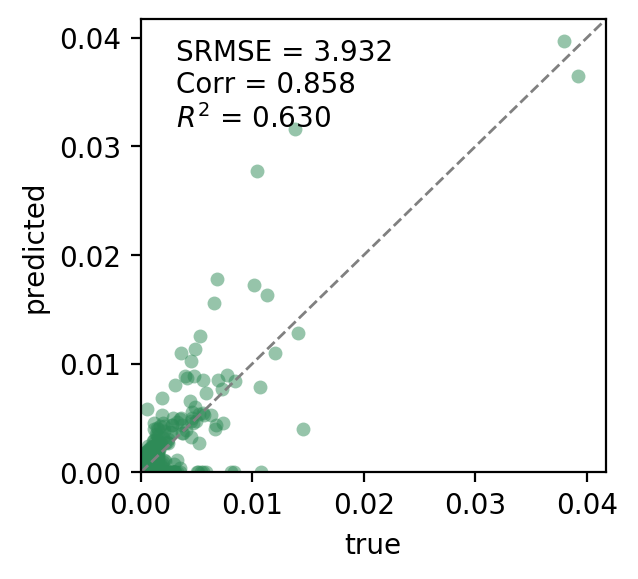

count_real  \
RespAgeCorrect     RespEdulevel RespSex ResphasDrivlic RespHasBicycle RespPrimOcc               
(0.00198, 0.00702] 1            2       -18            1              107            0.037898   
                                                                      116            0.000006   
                                                                      390            0.000012   
                                                                      103            0.000060   
                                                       2              107            0.002601   
...                                                                                       ...   
(0.0228, 0.0261]   8            1       2              2              310            0.000000   
                                2       2              1              120            0.000000   
                                                                      310            0.000000   
                                                       2              120            0.000000   
                                                                      310            0.000000   

                                                                                   count_sampled  \
RespAgeCorrect     RespEdulevel RespSex ResphasDrivlic RespHasBicycle RespPrimOcc                  
(0.00198, 0.00702] 1            2       -18            1              107               0.039689   
                                                                      116               0.000044   
                                                                      390               0.000011   
                                                                      103               0.000000   
                                                       2              107               0.003756   
...                                                                                          ...   
(0.0228, 0.0261]   8            1       2              2              310               0.000033   
                                2       2              1              120               0.000011   
                                                                      310               0.000011   
                                                       2              120               0.000011   
                                                                      310               0.000011   

                                                                                           diff  
RespAgeCorrect     RespEdulevel RespSex ResphasDrivlic RespHasBicycle RespPrimOcc                
(0.00198, 0.00702] 1            2       -18            1              107         -1.790716e-03  
                                                                      116         -3.846587e-05  
                                                                      390          8.460345e-07  
                                                                      103          5.978573e-05  
                                                       2              107         -1.154876e-03  
...                                                                                         ...  
(0.0228, 0.0261]   8            1       2              2              310         -3.333333e-05  
                                2       2              1              120         -1.111111e-05  
                                                                      310         -1.111111e-05  
                                                       2              120         -1.111111e-05  
                                                                      310         -1.111111e-05  

[6847 rows x 3 columns]

In [22]:
### This combination amounts to 128k different combinations
evaluate(data, fake,  ['RespAgeCorrect', 'RespEdulevel','RespSex', 'ResphasDrivlic', 'RespHasBicycle', 'RespPrimOcc'], data.columns, data, data)

MAE:1.959738016182605e-06, MSE:2.419768260783202e-08, RMSE:0.00015555604330218746, SRSME:0.13168974429636468
corr = 0.578456
MAE = 0.000178
RMSE = 0.001484
SRMSE = 11.689273
r2 = -3.099497


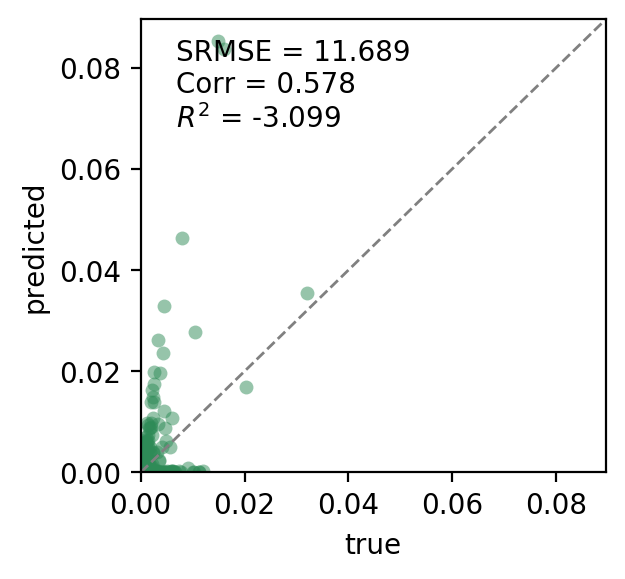

count_real  \
PosInFamily RespPrimOcc HousehNumAdults      RespEdulevel HousehNumPers1084                 
20          107         (0.001, 0.00107]     1            (0.00179, 0.00752]     0.004627   
                                                          (0.00143, 0.00179]     0.003019   
                                             9            (0.00179, 0.00752]     0.000012   
                                                          (0.00143, 0.00179]     0.000012   
                                             5            (0.00179, 0.00752]     0.000006   
...                                                                                   ...   
12          291         (0.000713, 0.000717] 12           (0.00071, 0.000716]    0.000000   
            277         (0.00107, 0.00556]   13           (0.00107, 0.00143]     0.000000   
            302         (0.00107, 0.00556]   2            (0.00107, 0.00143]     0.000000   
            191         (0.000717, 0.000721] 13           (0.00107, 0.00143]     0.000000   
            238         (0.000717, 0.000721] 12           (0.00107, 0.00143]     0.000000   

                                                                               count_sampled  \
PosInFamily RespPrimOcc HousehNumAdults      RespEdulevel HousehNumPers1084                    
20          107         (0.001, 0.00107]     1            (0.00179, 0.00752]        0.008811   
                                                          (0.00143, 0.00179]        0.000256   
                                             9            (0.00179, 0.00752]        0.000044   
                                                          (0.00143, 0.00179]        0.000000   
                                             5            (0.00179, 0.00752]        0.000022   
...                                                                                      ...   
12          291         (0.000713, 0.000717] 12           (0.00071, 0.000716]       0.000011   
            277         (0.00107, 0.00556]   13           (0.00107, 0.00143]        0.000011   
            302         (0.00107, 0.00556]   2            (0.00107, 0.00143]        0.000011   
            191         (0.000717, 0.000721] 13           (0.00107, 0.00143]        0.000011   
            238         (0.000717, 0.000721] 12           (0.00107, 0.00143]        0.000011   

                                                                                   diff  
PosInFamily RespPrimOcc HousehNumAdults      RespEdulevel HousehNumPers1084              
20          107         (0.001, 0.00107]     1            (0.00179, 0.00752]  -0.004184  
                                                          (0.00143, 0.00179]   0.002764  
                                             9            (0.00179, 0.00752]  -0.000032  
                                                          (0.00143, 0.00179]   0.000012  
                                             5            (0.00179, 0.00752]  -0.000016  
...                                                                                 ...  
12          291         (0.000713, 0.000717] 12           (0.00071, 0.000716] -0.000011  
            277         (0.00107, 0.00556]   13           (0.00107, 0.00143]  -0.000011  
            302         (0.00107, 0.00556]   2            (0.00107, 0.00143]  -0.000011  
            191         (0.000717, 0.000721] 13           (0.00107, 0.00143]  -0.000011  
            238         (0.000717, 0.000721] 12           (0.00107, 0.00143]  -0.000011  

[7879 rows x 3 columns]

In [23]:
### This combination amounts to 6m different combinations
evaluate(data, fake,  ['PosInFamily', 'RespPrimOcc', 'HousehNumAdults' ,'RespEdulevel', 'HousehNumPers1084'], data.columns, data, data)

MAE:1.5296461639953698e-13, MSE:5.2317602758025647e-17, RMSE:7.233090816381725e-09, SRSME:0.02417671112969064
corr = 0.367964
MAE = 0.000017
RMSE = 0.000076
SRMSE = 7.676058
r2 = -7.368563


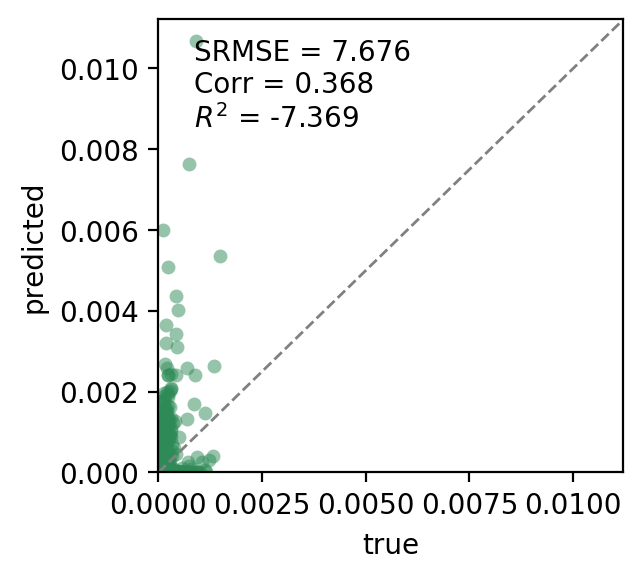

count_real  \
HomeAdrNUTS RespPrimOcc NuclFamType HousehAccOwnorRent HousehCarOwnership RespAgeCorrect     RespDrivlicYear            HousehNumcars        HousehNumPers        HousehNumAdults      HousehNumPers1084   HousehNumPersO6      HousehNumDrivLic                   
42          107         21          1                  1                  (0.00198, 0.00702] (-0.00050148, -0.00049775] (0.000363, 0.000502] (0.002, 0.0142]      (0.001, 0.00107]     (0.00179, 0.00752]  (0.002, 0.00752]     (0.000726, 0.001]       0.000138   
                                                                                                                                                                                                                                (0.000363, 0.000708]    0.000006   
                                                                                                                                                                                       (0.00143, 0.00179]  (0.002, 0.00752]     (0.000726, 0.001]       0.000060   
                                                                                                                                                                                                                                (0.000363, 0.000708]    0.000012   
                                                                                                                                                                                                           (0.00143, 0.002]     (0.000726, 0.001]       0.000006   
...                                                                                                                                                                                                                                                          ...   
14          280         20          1                  1                  (0.0202, 0.0228]   (0.71025, 0.71037]         (0.000358, 0.000361] (0.00107, 0.00142]   (0.00107, 0.00556]   (0.00107, 0.00143]  (0.00108, 0.00143]   (0.001, 0.00451]        0.000000   
            151         21          1                  1                  (0.0176, 0.0202]   (0.71018, 0.71022]         (0.000358, 0.000361] (0.00107, 0.00142]   (0.000717, 0.000721] (0.00107, 0.00143]  (0.00108, 0.00143]   (0.000717, 0.000721]    0.000000   
            335         20          3                  1                  (0.0124, 0.015]    (0.71132, 0.72137]         (0.000356, 0.000358] (0.00142, 0.00149]   (0.000713, 0.000717] (0.00071, 0.000716] (0.00108, 0.00143]   (0.000357, 0.000363]    0.000000   
            279         21          1                  2                  (0.0176, 0.0202]   (0.71058, 0.71132]         (0.000715, 0.000723] (0.00107, 0.00142]   (0.000717, 0.000721] (0.00107, 0.00143]  (0.00108, 0.00143]   (0.000717, 0.000721]    0.000000   
            259         10          2                  0                  (0.00904, 0.0124]  (-0.00053122, -0.00050148] (-0.001, 0.000356]   (0.000363, 0.000714] (0.000361, 0.000708] (0.000362, 0.00071] (0.000362, 0.000711] (-0.001, 0.000357]      0.000000   

                                                                                                                                                                                                                                                      count_sampled  \
HomeAdrNUTS RespPrimOcc NuclFamType HousehAccOwnorRent HousehCarOwnership RespAgeCorrect     RespDrivlicYear            HousehNumcars        HousehNumPers        HousehNumAdults      HousehNumPers1084   HousehNumPersO6      HousehNumDrivLic                      
42          107         21          1                  1                  (0.00198, 0.00702] (-0.00050148, -0.00049775] (0.000363, 0.000502] (0.002, 0.0142]      (0.001, 0.00107]     (0.00179, 0.00752]  (0.002, 0.00752]     (0.000726, 0.001]          0.000244   
                                                                            

In [24]:
### This combination amounts to 100b different combinations
evaluate(data, fake,  ['HomeAdrNUTS', 'RespPrimOcc','NuclFamType',
       'HousehAccOwnorRent', 'HousehCarOwnership', 'RespAgeCorrect',
       'RespDrivlicYear', 'HousehNumcars', 'HousehNumPers', 'HousehNumAdults',
       'HousehNumPers1084', 'HousehNumPersO6', 'HousehNumDrivLic'], data.columns, data, data)